# Intro

Code in this notebook is used for addressing our first research question:

**"Is there a significant association between diabetes and the following variables?"**

* Soda consumption among high school students
* Obesity among adults aged >= 18 years
* Overweight or obesity among adults aged >= 18 years
* Physical exercise
* Gender [categorical]
* Ethnicity [categorical]
* Poverty percentage
* Current lack of health insurance among adults aged 18-64 years
* Median daily frequency of fruit consumption among adults aged >= 18 years
* Hypertension (high Blood Pressure)
* Computer use among high school students
* Television viewing among high school students


In [12]:
# COPY THIS
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/data102')

Mounted at /content/drive


In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

from  tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install sodapy
from sodapy import Socrata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1


## Download CDI dataset

https://chronicdata.cdc.gov/Chronic-Disease-Indicators/U-S-Chronic-Disease-Indicators-CDI-/g4ie-h725

In [5]:
client = Socrata("chronicdata.cdc.gov", None)
results = client.get("g4ie-h725",
  where="topicid = 'DIA' OR topicid='NPAW' OR topicid='OVC' OR topicid='CVD'",
  limit=1000000
) # `where` is SQL-style
cdi_dia = pd.DataFrame.from_records(results)
len(cdi_dia)

463236

In [6]:
prev = cdi_dia[(cdi_dia['questionid'] == 'DIA2_1')
               & (cdi_dia['yearstart'] == '2014')
               & (cdi_dia['stratificationid1'] == 'OVR')
               & (cdi_dia['datavaluetypeid'] == 'CRDPREV')]
prev = prev[["locationabbr", "datavalue"]]
prev.columns = ['state', 'diabetes prevalence']
prev = prev.set_index('state')
prev.head()

,diabetes prevalence
state,
AK,7.4
AL,12.9
AR,12.7
AZ,10.0
CA,10.3


In [162]:
pvals_df = pd.DataFrame({'hypothesis': pd.Series(dtype='str'),
                         'pvalue': pd.Series(dtype=np.float64)})

# Stratified data (difference in group means)

* Gender: z-test proportions, Male vs. Female
* Age: z-test between consolidated groups, 18-44 vs. 45+ (45-64, 65-74, 75+)
* Ethnicity/Race: z-test, White vs. Non-White

In [163]:
# Diabetes prevalence rates between sex and age groups
diabetes = pd.read_csv("data/categorical_diabetes.csv")
diabetes = diabetes.set_index("State")
diabetes = diabetes.replace("No Data", "NaN")
diabetes = diabetes.astype(float).dropna()
diabetes.head()

,male,female,18-44,45-64,65-74,75+
State,,,,,,
Alabama,12.0,11.5,4.8,17.8,24.3,21.0
Alaska,6.7,8.6,1.8,10.3,21.3,21.0
Arizona,10.1,8.3,2.8,14.0,21.8,18.7
Arkansas,11.9,11.3,3.9,17.9,24.7,22.8
California,10.9,9.0,2.9,15.4,21.5,22.5


In [164]:
#from hw1
def mean_calculation(dataset, binary_col, numerical_col):
    data = dataset[[binary_col, numerical_col]]
    means_table = data.groupby(binary_col).mean().reset_index()
    means = means_table.iloc[:,1]
    observed_mean = abs(means[1] - means[0])
    return observed_mean

def avg_difference_in_means(dataset, binary_col, numerical_col, weight_col=None, reps=25000):
    observed_difference = mean_calculation(dataset, binary_col, numerical_col)
    
    differences = []
    for _ in tqdm(range(reps)):
        dataset["shuffled"] = dataset[binary_col].sample(len(dataset), weights=dataset[weight_col]).values
        shuffled_df = dataset[["shuffled", numerical_col]]
        new_mean = mean_calculation(shuffled_df, "shuffled", numerical_col)
        differences.append(new_mean) 
        
    p_val = np.mean(differences >= observed_difference)
    return p_val

## Gender

In [165]:
state_pops_gender = pd.read_csv("data/state_pop_by_gender_2014.csv")
state_pops_gender = state_pops_gender.melt(id_vars="State")
state_pops_gender.columns = ['State', 'Gender', 'Population']
state_pops_gender.head()

,State,Gender,Population
0,Alabama,male,2335261
1,Alaska,male,366924
2,Arizona,male,3330681
3,Arkansas,male,1452141
4,California,male,19033322


In [166]:
diabetes_gender = diabetes[["male", 'female']].reset_index()
diabetes_gender = pd.melt(diabetes_gender, id_vars='State', value_vars=["male", 'female'],
                          var_name='Gender', value_name='Prevalence')
diabetes_gender = diabetes_gender.merge(state_pops_gender, left_on=["State", "Gender"], right_on=["State", "Gender"], how='left').dropna()
diabetes_gender.head()

,State,Gender,Prevalence,Population
0,Alabama,male,12.0,2335261.0
1,Alaska,male,6.7,366924.0
2,Arizona,male,10.1,3330681.0
3,Arkansas,male,11.9,1452141.0
4,California,male,10.9,19033322.0


In [167]:
pval = avg_difference_in_means(diabetes_gender, 'Gender', 'Prevalence', weight_col="Population")
pvals_df.loc[len(pvals_df), :] = ['gender', pval]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [168]:
print("p value:", pval)

p value: 0.00016


## Age Groups

ANOVA doesn't work with proportions, so we can just consolidate young (18-44) vs old (45+)

In [169]:
pop_age = pd.read_csv("data/state_pop_by_age_group_2014.csv", index_col="State").dropna().astype(int)
pop_age['45+'] = pop_age.iloc[:, 1:4].sum(axis=1)
pop_age.head()

,18-44,45-64,65-74,75+,45+
State,,,,,
Alabama,1696835,1283789,434217,307775,2025781
Alaska,265580,192386,47156,22848,262390
Arizona,2401117,1626971,618175,442312,2687458
Arkansas,1034925,753929,269678,196016,1219623
California,14674439,9674485,2807886,2140895,14623266


In [170]:
diabetes_age = diabetes.iloc[:, 2:]
diabetes_age.loc[:, '45+'] = (diabetes_age.iloc[:, 1:4] * pop_age.iloc[:, 1:4]).sum(axis=1) / pop_age['45+']
diabetes_age = diabetes_age[["18-44", "45+"]].reset_index()
diabetes_age.head()

<ipython-input-170-828ec4dda77d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes_age.loc[:, '45+'] = (diabetes_age.iloc[:, 1:4] * pop_age.iloc[:, 1:4]).sum(axis=1) / pop_age['45+']


,State,18-44,45+
0,Alabama,4.8,19.679419
1,Alaska,1.8,13.208608
2,Arizona,2.8,16.567717
3,Arkansas,3.9,20.191109
4,California,2.9,17.610755


In [171]:
pop_age_melt = pop_age[["18-44", "45+"]].reset_index().melt(id_vars="State")
pop_age_melt.columns = ['State', 'Age', 'Population']
pop_age_melt.head()

,State,Age,Population
0,Alabama,18-44,1696835
1,Alaska,18-44,265580
2,Arizona,18-44,2401117
3,Arkansas,18-44,1034925
4,California,18-44,14674439


In [172]:
diabetes_age = pd.melt(diabetes_age, id_vars='State', value_vars=["18-44", "45+"],
                          var_name='Age', value_name='Prevalence')
diabetes_age = diabetes_age.merge(pop_age_melt, left_on=["State", "Age"], right_on=["State", "Age"], how='left').dropna()
diabetes_age.head()

,State,Age,Prevalence,Population
0,Alabama,18-44,4.8,1696835.0
1,Alaska,18-44,1.8,265580.0
2,Arizona,18-44,2.8,2401117.0
3,Arkansas,18-44,3.9,1034925.0
4,California,18-44,2.9,14674439.0


In [173]:
pval = avg_difference_in_means(diabetes_age, 'Age', 'Prevalence', weight_col="Population")
pvals_df.loc[len(pvals_df), :] = ['age', pval]
print("p value:", pval)

  0%|          | 0/25000 [00:00<?, ?it/s]

p value: 0.0


## Ethnicity

**TODO** - maybe split into white vs nonwhite?

- to do: find external dataset on population based on ethnicity
- finish other parts -- lets do this if there's time

In [31]:
white_diabetes = cdi_dia[(cdi_dia['questionid'] == 'DIA2_1')
               & (cdi_dia['yearstart'] == '2014')
               & (cdi_dia["stratificationcategoryid1"] == "RACE")
               & (cdi_dia["stratificationid1"] == "WHT")
               & (cdi_dia['datavaluetypeid'] == 'CRDPREV')]

non_white_diabetes = cdi_dia[(cdi_dia['questionid'] == 'DIA2_1')
               & (cdi_dia['yearstart'] == '2014')
               & (cdi_dia["stratificationcategoryid1"] == "RACE")
               & (cdi_dia["stratificationid1"] != "WHT")
               & (cdi_dia['datavaluetypeid'] == 'CRDPREV')]

In [32]:
desired_cols = ['locationabbr', 'datavaluealt', 'stratificationid1']
non_white_diabetes = non_white_diabetes[desired_cols]
white_diabetes = white_diabetes[desired_cols]

In [36]:
non_white_diabetes.groupby("locationabbr").agg({'datavaluealt': lambda x: x.astype(float).median()})

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,datavaluealt
locationabbr,
AK,5.90
AL,12.50
AR,18.65
AZ,10.50
CA,10.45
CO,8.85
CT,14.15
DC,14.80
DE,14.20


In [ ]:
race_columns = ['yearstart', 'locationdesc', 'datasource',
       'topic', 'question', 'datavaluetype', 'datavalue', 'datavaluealt',
       'stratificationcategory1', 'stratification1', 'geolocation',
       'locationid', 'topicid', 'questionid', 'datavaluetypeid',
       'stratificationcategoryid1', 'stratificationid1', 'datavalueunit',
       'lowconfidencelimit', 'highconfidencelimit', 'datavaluefootnotesymbol',
       'datavaluefootnote']

# Correlation Tests

## helper functions

In [174]:
import re
def question_lookup(question):
  query_res = cdi_dia[cdi_dia['question'].str.contains(question, flags=re.IGNORECASE)]
  matches = query_res['questionid'].unique()
  if len(matches) > 1:
    return [(a, b) for a,b in zip(query_res['question'].unique(), matches)]
  elif len(matches) == 0:
    print("No questions found.")
    return None

  print("found", query_res['question'].unique())
  return matches[0]

In [175]:
def correlation_test(x, y, weight=None):
  """
  Calculates p-value for either OLS or WLS for y = mx + const.
    (does WLS if weight is not None, otherwise OLS)

  X, Y, and WEIGHT should be pandas series (or 1-column DataFrames)
    with the state 2-letter abbreviations as indexes.
  """
  weighted = weight is not None
  X = sm.add_constant(x)

  if weighted:
    model = sm.WLS(y, X, weights=weight)
  else:
    model = sm.OLS(y, X)
  
  results = model.fit()
  pvals = results.pvalues

  return pvals[-1], results.params

In [230]:
def correlation_test_helper(cdi_questionid,
                            subset='adult',
                            year=2014,
                            stratificationid1='OVR',
                            datavaluetypeid='CRDPREV',
                            plot=False,
                            reg=['ols', 'wls']):
  year = str(year)

  xdata = cdi_dia[cdi_dia['questionid'] == cdi_questionid]

  if stratificationid1 not in xdata['stratificationid1'].unique():
    print("stratificationid1 must be one of", xdata['stratificationid1'].unique())
    return
  elif datavaluetypeid not in xdata['datavaluetypeid'].unique():
    print("datavaluetypeid must be one of", xdata['datavaluetypeid'].unique())
    return
  elif year not in xdata['yearstart'].unique():
    print("Year must be one of", xdata['yearstart'].unique())
    return

  xdata = xdata[
      (xdata['stratificationid1'] == stratificationid1)
      & (xdata['datavaluetypeid'] == datavaluetypeid)
      & (xdata['yearstart'] == year)]
  xdata = xdata[["locationabbr", "datavalue"]]
  xdata = xdata.set_index('locationabbr')

  # load population data for weight
  if subset == 'adult':
    weight = pd.read_csv("data/adult_pop_2014.csv", index_col=0)
    weight = weight.set_index('Postal')['adult population']
  elif subset == 'hs':
    weight = pd.read_csv("data/hs_aged_pop_2013.csv", index_col=0)
    weight = weight.set_index('Postal')['num HS age']
  else:
    weight=None

  # join data and drop missing data
  if weight is not None:
    df = xdata.join([prev, weight], how="inner").astype(float).dropna()
  else:
    df = xdata.join(prev, how="inner").astype(float).dropna()
    w=None

  if len(df) <= 1:
    print("Not enough data for regression.")
    return
  
  print(f"regressing on {len(df)} samples")
  
  x = df.iloc[:, 0]
  y = df.iloc[:, 1]

  if 'ols' in reg:
    pval_ols, coeffs_ols = correlation_test(x, y)
  if 'wls' in reg:
    w = df.iloc[:, 2]
    pval_wls, coeffs_wls = correlation_test(x, y, w)

  if plot:
    sns.scatterplot(x=x, y=y, size=w, legend=None)

    xx = np.array([x.min(), x.max()])
    if 'wls' in reg:
      b, m = coeffs_wls
      plt.plot(xx, b + m*xx, c='green', label="WLS line (pval=" + str(round(pval_wls, 15)) + ")")
    
    if 'ols' in reg:
      b, m = coeffs_ols
      plt.plot(xx, b + m*xx, c='red', label="OLS line (pval=" + str(round(pval_ols, 15)) + ")")

    plt.legend()
  
  pvals = {}
  if 'wls' in reg: pvals['wls'] = pval_wls
  if 'ols' in reg: pvals['ols'] = pval_ols
  return pvals

## Soda consumption among high school students

Question ID: NPAW12_2

**Q1:** is this really relevant? current high school behavior won't cause current diabetes. do we have any older data we can use?

**Q2:** in a regular correlation test, every state (regardless of size) is getting treated the same when measuring correlation. do we want to do a weighted measurement? (did both so we can choose ig)

regressing on 38 samples


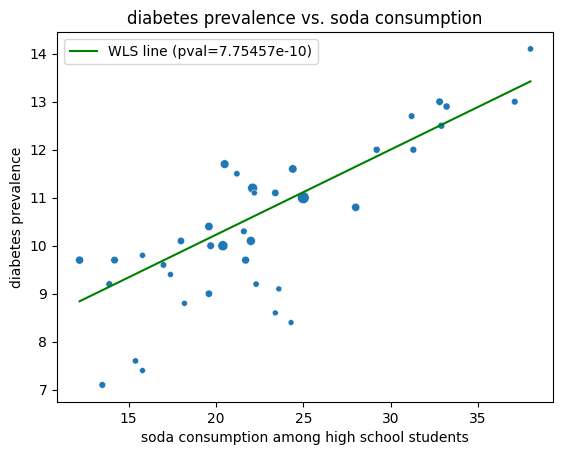

In [233]:
soda = correlation_test_helper('NPAW12_2', 'hs', 2013, plot=True, reg='wls')
plt.xlabel("soda consumption among high school students")
plt.title("diabetes prevalence vs. soda consumption")
plt.savefig("figures/soda_diabetes.png")

In [ ]:
pvals_df.loc[len(pvals_df), :] = ['soda consumption', soda['wls']]

## Obesity among adults aged >= 18 years

Question ID: NPAW1_1

regressing on 51 samples


{'wls': 3.7872355712106028e-06}

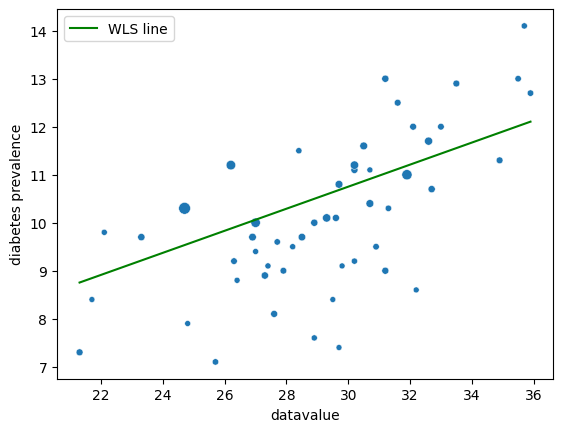

In [178]:
obesity = correlation_test_helper('NPAW1_1', 'adult', 2014, plot=True, reg="wls")
pvals_df.loc[len(pvals_df), :] = ['obesity', obesity['wls']]
obesity

## Overweight or obesity among adults aged >= 18 years

Question ID: NPAW2_1

In [179]:
overweight_obesity = correlation_test_helper('NPAW2_1', 'adult', 2014, reg="wls")
pvals_df.loc[len(pvals_df), :] = ['overweight or obesity', overweight_obesity['wls']]
overweight_obesity

regressing on 51 samples


{'wls': 3.736049286113199e-05}

## Meeting aerobic physical activity guidelines for substantial health benefits among adults aged >= 18 years

regressing on 51 samples


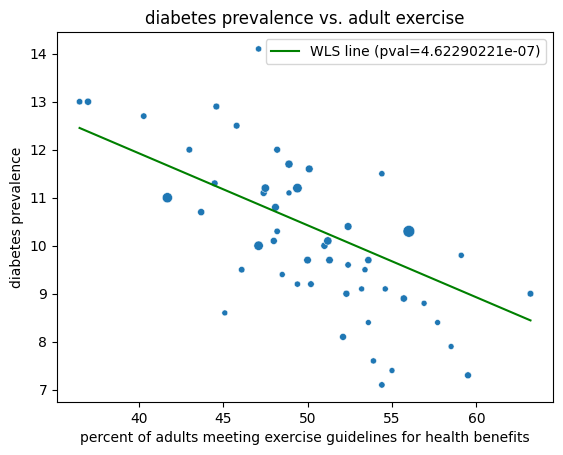

In [247]:
activity = correlation_test_helper('NPAW11_1', 'adult', 2013, plot=True, reg='wls')
plt.xlabel("percent of adults meeting exercise guidelines for health benefits")
plt.title("diabetes prevalence vs. adult exercise")
plt.savefig("figures/exercise_diabetes.png")

In [ ]:
pvals_df.loc[len(pvals_df), :] = ['physical activity', activity['wls']]

## Poverty Percentage

Question ID: OVC3_1

regressing on 51 samples


{'wls': 1.8873477812033962e-08}

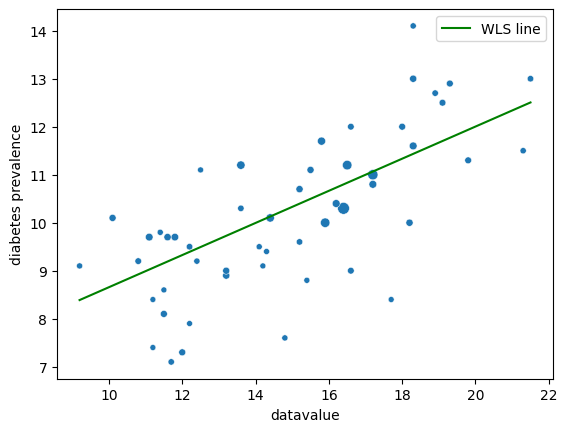

In [181]:
poverty = correlation_test_helper('OVC3_1', 'adult', 2014, plot=True, reg="wls")
pvals_df.loc[len(pvals_df), :] = ['poverty percentage', poverty['wls']]
poverty

## Current lack of health insurance among adults aged 18-64 years

Question ID: OVC1_1

regressing on 51 samples


{'wls': 0.0057529276462077025}

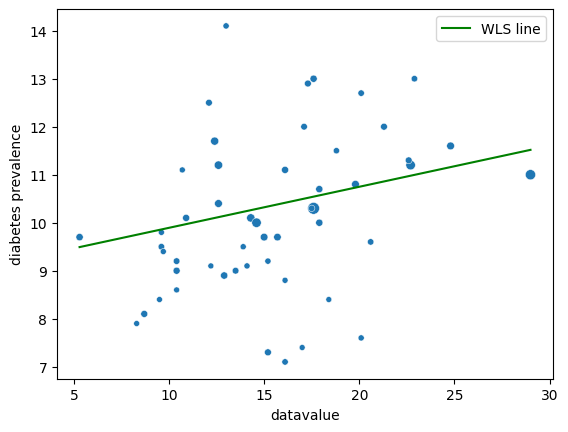

In [182]:
insurance = correlation_test_helper('OVC1_1', 'adult', 2014, plot=True, reg="wls")
pvals_df.loc[len(pvals_df), :] = ['lack of health insurance', insurance['wls']]
insurance

## Median daily frequency of fruit consumption among adults aged >= 18 years

Question ID: OVC1_1

In [ ]:
question_lookup("fruit consumption among adults")

found ['Median daily frequency of fruit consumption among adults aged >= 18 years']


'NPAW4_2'

regressing on 51 samples


{'wls': 0.07527940134586408}

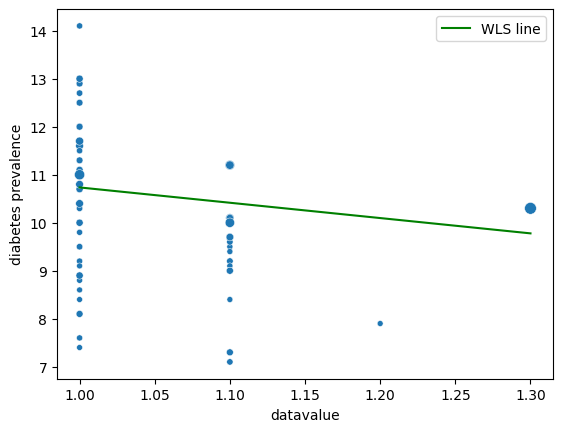

In [183]:
fruit = correlation_test_helper('NPAW4_2', 'adult', 2013, reg="wls", datavaluetypeid='MEDIAN', plot=True)
pvals_df.loc[len(pvals_df), :] = ['fruit consumption', fruit['wls']]
fruit

## Taking medicine for high blood pressure control among adults aged >= 18 years with high blood pressure

In [ ]:
question_lookup("blood pressure")

[('Awareness of high blood pressure among women aged 18-44 years', 'CVD6_2'),
 ('Awareness of high blood pressure among adults aged >= 18 years', 'CVD6_1'),
 ('Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes',
  'DIA11_2'),
 ('Taking medicine for high blood pressure control among adults aged >= 18 years with high blood pressure',
  'CVD7_0')]

regressing on 51 samples


{'wls': 1.9131224434304085e-06}

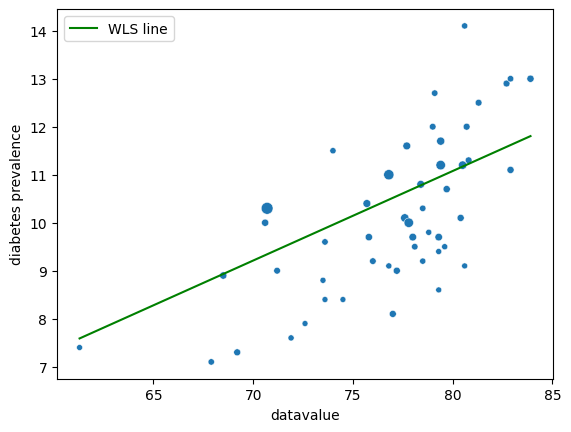

In [184]:
bp = correlation_test_helper('CVD7_0', 'adult', 2013, reg="wls", plot=True)
pvals_df.loc[len(pvals_df), :] = ['taking medicine for high blood pressure', bp['wls']]
bp

## Computer use among high school students

In [236]:
question_lookup("computer")

found ['Computer use among high school students']


'NPAW21_0'

regressing on 40 samples


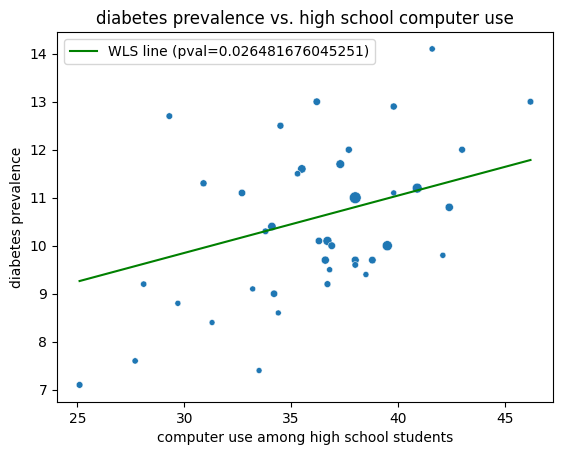

In [235]:
computer = correlation_test_helper('NPAW21_0', 'hs', 2013, reg="wls", plot=True)
plt.xlabel("computer use among high school students")
plt.title("diabetes prevalence vs. high school computer use")
plt.savefig("figures/computer_diabetes.png")

In [ ]:
pvals_df.loc[len(pvals_df), :] = ['computer use', computer['wls']]

## Television viewing among high school students

In [ ]:
question_lookup("television")

found ['Television viewing among high school students']


'NPAW20_0'

regressing on 40 samples


{'wls': 1.962193805660829e-08}

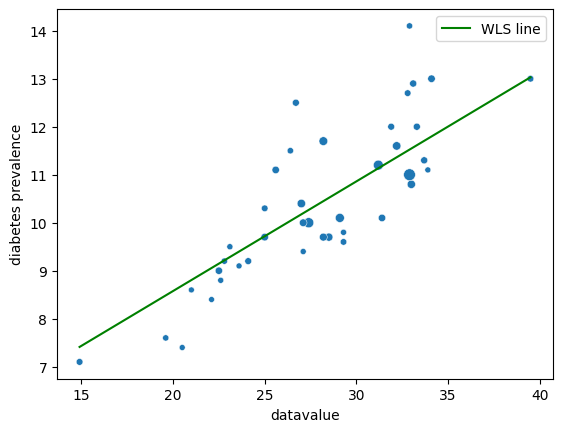

In [186]:
tv = correlation_test_helper('NPAW20_0', 'hs', 2013, reg="wls", plot=True)
pvals_df.loc[len(pvals_df), :] = ['television use', tv['wls']]
tv

# Controlling Error rates

In [217]:
pvals_df = pvals_df.sort_values(by='pvalue')[['hypothesis', 'pvalue']]
pvals_df

,hypothesis,pvalue
2,age,0.000000e+00
3,soda consumption,7.754571e-10
7,poverty percentage,1.887348e-08
12,television use,1.962194e-08
6,physical activity,4.622902e-07
10,taking medicine for high blood pressure,1.913122e-06
4,obesity,3.787236e-06
5,overweight or obesity,3.736049e-05
1,gender,1.600000e-04
8,lack of health insurance,5.752928e-03


In [238]:
# Naive
pvals_df["No control"] = (pvals_df['pvalue'] <= 0.05)

In [239]:
# B-Y Correction
import statsmodels.stats
pvals_df["B-Y"] = statsmodels.stats.multitest.fdrcorrection(pvals_df['pvalue'],
                                                            alpha=0.05,
                                                            method='n',
                                                            is_sorted=True)[0]

In [240]:
# Bonferroni Correction 
m = len(pvals_df)
alpha = 0.05
bonf_threshold = alpha/m
pvals_df["Bonferroni"] = (pvals_df['pvalue'] <= bonf_threshold)

In [241]:
pvals_df

,hypothesis,pvalue,No control,B-Y,Bonferroni
2,age,0.000000e+00,True,True,True
3,soda consumption,7.754571e-10,True,True,True
7,poverty percentage,1.887348e-08,True,True,True
12,television use,1.962194e-08,True,True,True
6,physical activity,4.622902e-07,True,True,True
10,taking medicine for high blood pressure,1.913122e-06,True,True,True
4,obesity,3.787236e-06,True,True,True
5,overweight or obesity,3.736049e-05,True,True,True
1,gender,1.600000e-04,True,True,True
8,lack of health insurance,5.752928e-03,True,True,False


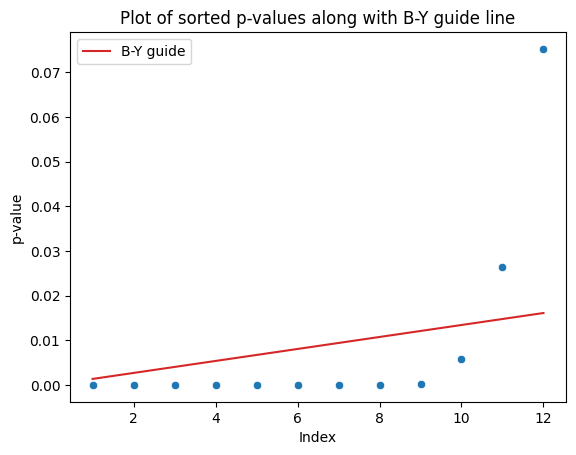

In [215]:
index = np.arange(1, m+1)
cm = np.sum(1 / np.arange(1, m+1))

sns.scatterplot(x=index, y=pvals_df['pvalue'])
plt.plot(index, index/(m*cm) * alpha, label='B-Y guide', color='tab:red')

plt.title("Plot of sorted p-values along with B-Y guide line")
plt.xlabel("Index")
plt.ylabel("p-value")
plt.legend()

plt.savefig("figures/BY.png")